In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')#, '../pypfopt_local/pypfopt'])
from util.batcher import Batcher
#from util.stock_loader import Loader

In [3]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 8, 22), datetime.date(2022, 8, 20))

In [4]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,stry,3.398456
3,lly,3.048137
4,eve,2.531150


<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq listings</a>

In [9]:
#KEEP_TOP_N = 50
sym = (
    'avct amwd crmt amab abcb atlo amst amgn amcs fold amis amkr ampx '
    'shun amph ampg amhc ampl amsg asys amln amlx amrs anac ands adi '
    'anly anab anen avxl acom abcw agcc ande anda andw adrx aneb angh '
    'angi ango angn anpi anik anix annb annx anor ansl anst answ atrs '
    'aehl atex adal anzu apls apex apxt apgn apha apht atny apic apog '
)
missing = (
    'atrs anpi ands apht amab amsg apxt answ amhc amcs anor anst ampx '
    'andw anda amis agcc shun aha atny abcw amln ansl apex adrx apha'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [10]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  40 of 40 completed


,avct,amwd,crmt,abcb,atlo,amst,amgn,fold,amkr,amph,...,annb,annx,aehl,atex,adal,anzu,apls,apgn,apic,apog
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-22,10.896233,30.240000,NaN,31.342892,57.124935,64.916725,4.800490,NaN,NaN,NaN,...,NaN,NaN,13.739810,3.88,NaN,14.723426,NaN,4.36,45.119999,4.96
2012-08-23,10.714478,31.100000,NaN,31.240244,55.621651,64.754173,4.731490,NaN,NaN,NaN,...,NaN,NaN,13.399715,3.99,NaN,14.373699,NaN,4.12,45.240002,4.95
2012-08-24,10.850795,30.629999,NaN,31.374464,55.621651,65.474022,4.642774,NaN,NaN,NaN,...,NaN,NaN,13.663289,3.98,NaN,14.695453,NaN,4.04,45.279999,4.95
2012-08-27,10.896233,30.650000,NaN,31.263937,55.406891,65.350174,4.554058,NaN,NaN,NaN,...,NaN,NaN,13.629279,3.97,NaN,14.681466,NaN,4.16,45.490002,4.95
2012-08-28,10.941674,30.780001,NaN,31.224455,52.829830,65.025108,4.623060,NaN,NaN,NaN,...,NaN,NaN,13.586768,3.91,NaN,14.835343,NaN,4.40,44.740002,4.90


In [11]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [12]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [13]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])

In [14]:
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
2,crmt,1.860022
26,ango,1.725669
18,anab,1.115389
7,fold,1.048351
25,angi,0.911400
31,annx,0.810373
3,abcb,0.722518
30,annb,0.711159
5,amst,0.668073
0,avct,0.618823


In [15]:
sharpes_df = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes_df.drop_duplicates(subset=['stock'], inplace=True)
sharpes_df.index = sharpes_df['stock']
sharpes_df.drop(columns=['stock'], inplace=True)

sharpes_df.head(20)

,sharpe
stock,
ASAN,4.146624
efc,3.530101
stry,3.398456
lly,3.048137
eve,2.531150
chmt,2.475858
hhs,2.406309
bxsl,2.249160
dwin,1.886962


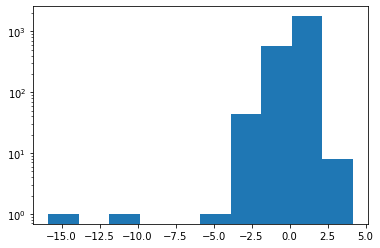

In [16]:
plt.hist(sharpes_df.sharpe)
plt.yscale('log');

In [17]:
sharpes.loc[sharpes.stock == 'sfg', :]

,stock,sharpe


In [18]:
omit = 'dcue'
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [19]:
sharpes.to_csv('sharpes.csv', index=False)

In [20]:
sharpes.shape

(2652, 2)

In [21]:
MIX = sharpes.stock.unique().tolist()[:400]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  400 of 400 completed
(2517, 400)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-08-22  32.356670  4.443465  16.491516 NaN  6.904176  NaN  20.028160   
2012-08-23  32.407871  4.428823  16.507767 NaN  6.929576  NaN  19.982416   
2012-08-24  32.510265  4.446392  16.678371 NaN  6.980373  NaN  20.112024   
2012-08-27  32.373741  4.428823  16.572763 NaN  6.925343  NaN  20.142521   
2012-08-28  31.998302  4.427359  16.524019 NaN  6.988841  NaN  20.104408   

                                            ...                            \
                 AEG        AEL        AEO  ... WDH       WLYB        WMT   
Date                                        ...                             
2012-08-22  3.520297  10.631600  15.446461  ... NaN  37.482006  57.378777   
2012-08-23  3.460967  10.495297  15.271956  ... NaN  37.482006  57.210876   
2012-08-24  3.388451  10.513471  15.327800  ... NaN  37.482006  57.650597   
2012-08-27  3.408228  10.468038  15.334778  ... NaN  37.178284  57.962402   
2012-08-28  3.434597  10.540730  15.383640  ... NaN  37.349625  57.890469   

                                                                
           WNNR WPCA        WRE        WSO        XOM XPOA YOU  
Date                                                            
2012-08-22  NaN  NaN  17.281746  52.323055  57.543831  NaN NaN  
2012-08-23  NaN  NaN  17.249273  52.049324  57.268356  NaN NaN  
2012-08-24  NaN  NaN  17.327209  52.449421  57.753735  NaN NaN  
2012-08-27  NaN  NaN  17.372667  52.407307  57.550381  NaN NaN  
2012-08-28  NaN  NaN  17.353182  52.688091  57.786537  NaN NaN  

[5 rows x 400 columns]

In [22]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2517, 230)


,ASAN,efc,stry,eve,hhs,bxsl,dwin,swi,pnw,irs,...,hr,mixt,thr,tinv,ohi,jbgs,cni,rcc,cah,tslx
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-22,32.356670,4.443465,16.491516,6.904176,20.028160,3.520297,10.631600,15.446461,19.099117,5.075938,...,29.863949,7.605406,8.464207,38.603336,11.291137,37.482006,57.378777,17.281746,52.323055,57.543831
2012-08-23,32.407871,4.428823,16.507767,6.929576,19.982416,3.460967,10.495297,15.271956,18.800074,5.137951,...,29.642467,7.587931,8.438528,38.193771,11.091935,37.482006,57.210876,17.249273,52.049324,57.268356
2012-08-24,32.510265,4.446392,16.678371,6.980373,20.112024,3.388451,10.513471,15.327800,19.268581,5.093657,...,29.528229,7.601032,8.412855,38.112816,11.408849,37.482006,57.650597,17.327209,52.449421,57.753735
2012-08-27,32.373741,4.428823,16.572763,6.925343,20.142521,3.408228,10.468038,15.334778,19.129026,5.102515,...,29.761360,7.614141,8.216013,37.450848,11.517505,37.178284,57.962402,17.372667,52.407307,57.550381
2012-08-28,31.998302,4.427359,16.524019,6.988841,20.104408,3.434597,10.540730,15.383640,19.019373,5.102515,...,29.700743,7.566083,8.207455,37.307976,11.689540,37.349625,57.890469,17.353182,52.688091,57.786537


In [23]:
#import cvxpy
#cvxpy.installed_solvers()

In [24]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s, solver='ECOS')# , verbose=True)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

fmc   : 0.01162
hrl   : 0.01511
sxt   : 0.04915
rad   : 0.01708
trv   : 0.04243
mov   : 0.02764
crhc  : 0.03084
hmn   : 0.12265
kar   : 0.01385
fif   : 0.07911
eqgp  : 0.01379
dma   : 0.08535
renx  : 0.18417
msge  : 0.12618
gcv   : 0.11833
rc    : 0.04399
cah   : 0.0187


In [25]:
ret, vol, sh = ef.portfolio_performance(verbose=True)

Expected annual return: 22.2%
Annual volatility: 13.0%
Sharpe Ratio: 1.56


In [26]:
ret, sh

(0.2222720780937931, 1.5553570370146208)

In [27]:
vol = np.linspace(0.10, 0.30, 50)
rets = []
sharpes = []
for v in vol:
    print(f'Vol: {v}   ', end='\r')
    ef = EfficientFrontier(mu, s, solver='ECOS')
    w = ef.efficient_risk(target_volatility=v)
    r, _, sh = ef.portfolio_performance()
    rets.append(r)
    sharpes.append(sh)

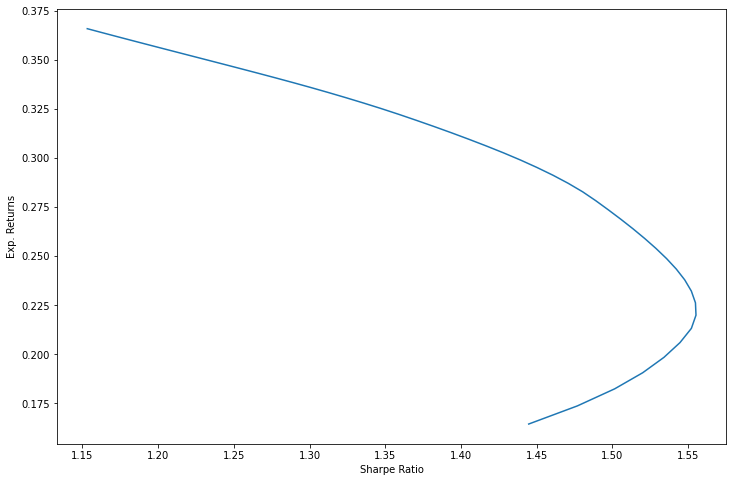

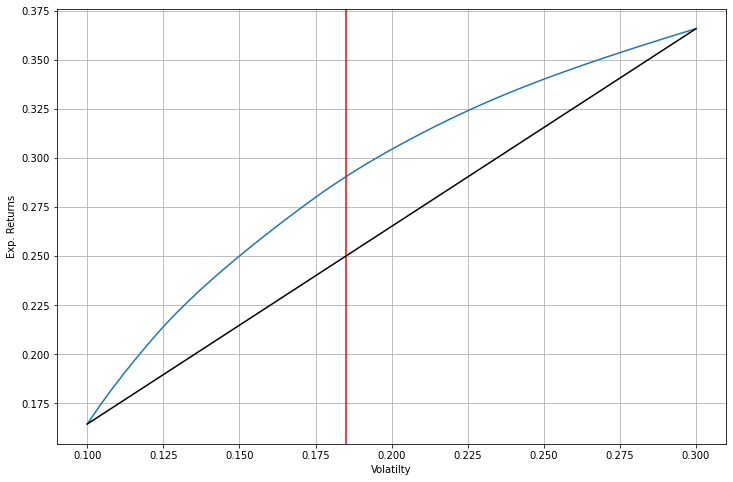

In [28]:
plt.figure(figsize=[12,8])
plt.plot(sharpes, rets)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Exp. Returns');

plt.figure(figsize=[12,8])
plt.plot(vol, rets)
plt.grid(True)
plt.axvline(x=0.185, color='r')
plt.plot([0.1, 0.3], [rets[0], rets[-1]], color='k')
plt.xlabel('Volatilty')
plt.ylabel('Exp. Returns');

In [29]:
OPTIMAL_VOL = 0.185
ef = EfficientFrontier(mu, s, solver='ECOS')
weights = ef.efficient_risk(target_volatility=OPTIMAL_VOL)
cleaned_weights = dict(ef.clean_weights())
weights = {k: v for k, v in cleaned_weights.items() if v > 0}
for k, v in weights.items():
    print(f'{k:6s}: {v}')

fmc   : 0.02791
hrl   : 0.01613
sxt   : 0.04492
hmn   : 0.19817
kar   : 0.02344
fif   : 0.10246
eqgp  : 0.05322
dma   : 0.03166
msge  : 0.22657
gcv   : 0.23792
rc    : 0.03761


In [30]:
ret, vol, sh = ef.portfolio_performance(verbose=True)

Expected annual return: 29.1%
Annual volatility: 18.5%
Sharpe Ratio: 1.46


In [31]:
ret, sh

(0.29056362891994314, 1.462506098170794)

In [32]:
sharpes_df.loc[weights.keys(), 'sharpe']

stock
fmc     1.546894
hrl     1.320501
sxt     0.992081
hmn     0.770981
kar     0.766604
fif     0.740030
eqgp    0.735395
dma     0.695828
msge    0.664737
gcv     0.663361
rc      0.660977
Name: sharpe, dtype: float64